# Preprocess the Pancreas data

In [1]:
import scvelo as scv
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

In [3]:
# standard preprocessing steps from scVelo
adata2000 = scv.datasets.pancreas()
scv.pp.filter_genes(adata2000, min_shared_counts=20)
scv.pp.normalize_per_cell(adata2000)
scv.pp.filter_genes_dispersion(adata2000, n_top_genes=2000)
scv.pp.log1p(adata2000)
scv.pp.moments(adata2000, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
#  #  stochastic model
# scv.tl.velocity(adata2000)


In [ ]:
# scv.tl.velocity_graph(adata2000, n_jobs=8)

In [4]:
# Using dynamical model (see paper) to calculate gene velocity
scv.tl.recover_dynamics(adata2000, n_jobs=8)
scv.tl.velocity(adata2000, mode='dynamical')

recovering dynamics (using 8/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:07:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [5]:
# computing velocity graph
scv.tl.velocity_graph(adata2000, n_jobs=8)

computing velocity graph (using 1/12 cores)
    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
adata2000

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [2]:
# processed data saved, just need to read in when rerun
# adata2000.write('data/pancreasd2000.h5ad', compression='gzip')
adata2000 = scv.read('data/pancreasd2000.h5ad')

Comparing the velocity graphs calculated based on full data vs top 2000 gene data and they are pretty different

In [ ]:

# adataTop = scv.read('data/pancreasTop5000.h5ad')
# adata = scv.read('data/pancreas.h5ad')

# import pickle
# layout_r = pickle.load(open("layout_r.pkl","rb"))[0]
# skeleton_r = pickle.load(open("skeleton_r.pkl","rb"))

# np.sum((adata2000.uns["velocity_graph"] - adata.uns["velocity_graph"]).power(2))


In [ ]:
# scv.pl.velocity_embedding_stream(adata2000, basis='umap')

# df = adata2000.var
# df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

# kwargs = dict(xscale='log', fontsize=16)
# with scv.GridSpec(ncols=3) as pl:
#     pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
#     pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
#     pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

# scv.get_df(adata2000, 'fit*', dropna=True).head()

# scv.tl.latent_time(adata2000)
# scv.pl.scatter(adataTop, color='latent_time', color_map='gnuplot', size=80) 

# top_genes = adata2000.var['fit_likelihood'].sort_values(ascending=False).index[:300]
# scv.pl.heatmap(adataTop, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

In [ ]:

# velocity = adataTop.layers["velocity"]
# np.sum(np.isnan(velocity))
# hasvelo = np.logical_not( np.isnan(velocity[0]) )
# velocity = velocity[:,hasvelo]
# adataTop_v = adataTop[:,hasvelo]

# Manual compute cosine similarity

In [ ]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import skeleton_methods.skeleton as skel
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
from scipy.stats import gaussian_kde
import collections
from collections import defaultdict
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from scipy.spatial import distance_matrix
import igraph
from numpy.linalg import norm

import random
 
random.seed(123)

There are several things the method did to before computing the cosine similarity:

. First, for the the location feature, instead of using the total gene counts (data.X), the algorithm by default uses data.layers["Ms"], which is the dense matrix with first order moments of spliced counts.

. Second, only genes under "velocity_genes" are included for computation

. only leave none na genes for the computation

. dX is defined as Xj - Xi, and then dX is centered by subtracting the mean of the vector, which doesn't really affect the cosine computation. V is also centered

In [ ]:
# specify the location features and velocity

X = adata2000.layers["Ms"]
V = adata2000.layers["velocity"]

subset = np.ones(adata2000.n_vars, bool)
subset &= np.array( adata2000.var["velocity_genes"].values, dtype = bool)
X = X[:, subset]
V = V[:, subset]
nans = np.isnan(np.sum(V, axis=0))
if np.any(nans):
    X = X[:, ~nans]
    V = V[:, ~nans]
V -= np.nanmean(V, axis =1)[:,None]

In [ ]:

X.shape

(3696, 1027)

In [ ]:
# xdiff = (X[3690]-  X[0])
# xdiff = xdiff - xdiff.mean()
# xdiff = np.sqrt(np.abs(xdiff))* np.sign(xdiff)

In [ ]:
# V = np.sqrt(np.abs(V))* np.sign(V)

# Skeleton constructed based on Ms features

In [ ]:
import skeleton_methods.skeleton as skel
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
from scipy.stats import gaussian_kde
import collections
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from scipy.spatial import distance_matrix
import igraph

import random
 
random.seed(123)

In [ ]:
# define the knot construction function
def constructKnots(X, centers = None, labels = None, k = None, rep = 100):
    """
      construct knots using overfitting kMeans
  
      Parameters
      ----------
      X : np.array
          the data ndarray
      centers: np.array of the knots, can be provided
      labels: np.array of the knot label that each data point belongs to
      k: the number of knots
      rep: times of random initialization for kMeans
  
      Returns
      -------
      centers: ndarray of the constructed knots
      cluster: array of knot labels to which the data points belong to
      nknots: number of knots
      withinss: within cluster sum of squares for each Voronoi cell corresponding to the knots
    """
    n, d = X.shape
    #construct knots
    if centers is None and labels is None:
        # Overfitting k-means
        #setting the number of knots k
        if k is None:
            k = round(np.sqrt(n))
    
        km = KMeans(n_clusters = k, n_init = rep)
        km.fit(X)
        centers = km.cluster_centers_
        labels = km.labels_
    
    elif labels is None:#centers provided but not labels
        nbrs = NearestNeighbors(n_neighbors=1).fit(centers)
        labels = nbrs.kneighbors(X, return_distance=False)
        labels = np.array([sublist[0] for sublist in labels])
        k = len(centers)
          
    elif centers is None:#labels provided but not centers
        elements_count = collections.Counter(labels)
        k = len(elements_count.items())
        centers = np.array([[0.0 for col in range(d)] for row in range(k)])
        for key, value in elements_count.items():
            centers[key,] = np.mean(X[labels == key,], axis=0)
      
    else:
        k = len(centers)
        
      
    withinss = np.array([0.0]*k)
    for i in range(k):
        withinss[i] = np.sum(np.square(X[labels == i,:]-centers[i,:]))
      
    return {"centers":centers, "cluster":labels, "nknots":k, "withinss": withinss}

In [ ]:
X.shape

(3696, 1027)

In [ ]:
# construct knots
conKnots = constructKnots(X, k = 100)
skeleton = conKnots
edgeWeights = skel.skelWeights(X, conKnots, wedge = ['voronoi'])
skeleton.update(edgeWeights)
X_nn = skeleton["nn"]
knots = skeleton["centers"]
kkdists = distance_matrix(knots,knots)

In [ ]:
# Compute the cluster sizes
knotSizes = np.zeros(100)
for i in range(100):
    knotSizes[i]= sum(X_nn[:,0] == i)
sum(knotSizes<5)

0

In [ ]:
#filter out small clusters and reconstruct
knots = np.array(knots[knotSizes>=5,:])
conKnots = constructKnots(X, centers= knots)
skeleton = conKnots
edgeWeights = skel.skelWeights(X, conKnots, wedge = ['voronoi'])
skeleton.update(edgeWeights)

In [ ]:
# recompute cluster sizes
X_nn = skeleton["nn"]
knots = skeleton["centers"]
kkdists = distance_matrix(knots,knots)
knotSizes = np.zeros(len(knots))
for i in range(len(knots)):
    knotSizes[i]= sum(X_nn[:,0] == i)

In [ ]:
# compute the voronoi similarity between knots, which is counting the data points with the pair of knots as the two closest knots.
# These weights can be used for approximate Delaunnay triangulation
m = knots.shape[0]
voron_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
for i in range(m-1): #loop through knots pairs
    center1 = knots[i]
    wi1 = np.where(X_nn[:,0] == i)[0]
    wi2 = np.where(X_nn[:,1] == i)[0]
    for j in range(i+1,m):
        center2 = knots[j]
        wj1 = np.where(X_nn[:,0] == j)[0]
        wj2 = np.where(X_nn[:,1] == j)[0]
        #data point indices within 2nn neighborhood of knots i, j
        nn2ij = np.union1d(np.intersect1d(wi1, wj2), np.intersect1d(wi2, wj1))
    
        if len(nn2ij) < 1 :#not in Delaunnay Triangulation
            voron_weights[i,j] = 0.0
            continue
    
        # Euclidean distance between two centers
        d12 = kkdists[i,j]

        #compute the Voronoi density 
        voron_weights[i,j] = len(nn2ij)/d12

In [ ]:
skeleton.update( {"voron_weights": voron_weights + np.transpose((voron_weights))})

In [ ]:
# To get major cell types within each voronoi cell
from collections import defaultdict
X_nn = skeleton["nn"]
knots = skeleton["centers"]

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adata2000.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

In [ ]:
# print to examine cell types within each region
for i in range(len(knots)):
    print(i)
    print(knotClusbyCell[i])

0
clusters
Ngn3 high EP     66
Pre-endocrine     1
Ductal            0
Ngn3 low EP       0
Beta              0
Alpha             0
Delta             0
Epsilon           0
Name: count, dtype: int64
1
clusters
Beta             37
Ductal            0
Ngn3 low EP       0
Ngn3 high EP      0
Pre-endocrine     0
Alpha             0
Delta             0
Epsilon           0
Name: count, dtype: int64
2
clusters
Beta             11
Ductal            0
Ngn3 low EP       0
Ngn3 high EP      0
Pre-endocrine     0
Alpha             0
Delta             0
Epsilon           0
Name: count, dtype: int64
3
clusters
Ductal           104
Ngn3 low EP       23
Ngn3 high EP       0
Pre-endocrine      0
Beta               0
Alpha              0
Delta              0
Epsilon            0
Name: count, dtype: int64
4
clusters
Pre-endocrine    50
Ductal            0
Ngn3 low EP       0
Ngn3 high EP      0
Beta              0
Alpha             0
Delta             0
Epsilon           0
Name: count, dtype: int64
5
clust

In [ ]:
# knots to further split and refine
refineId = [17,24,35,38,55,78,81,88,99]
for id in refineId:
    knots[id,:] = np.mean( X[np.logical_and( X_nn[:,0] == id , adata2000.obs['clusters'] == knotClusbyCell[id].index[0]),:], axis= 0)
    knots = np.vstack((knots, 
                       np.mean( X[np.logical_and( X_nn[:,0] == id , adata2000.obs['clusters'] != knotClusbyCell[id].index[0]),:], axis= 0)))

In [ ]:
# recalculate skeleton quantities based on refined knots
conKnots = constructKnots(X, centers= np.array(knots))
skeleton_r = conKnots
edgeWeights = skel.skelWeights(X, conKnots, wedge = ['voronoi'])
skeleton_r.update(edgeWeights)

In [ ]:
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]
kkdists = distance_matrix(knots,knots)
knotSizes = np.zeros(len(knots))
for i in range(len(knots)):
    knotSizes[i]= sum(X_nn[:,0] == i)
min(knotSizes)

8.0

In [ ]:
# Use closest observations for the knots for UMAP plotting. Save time for UMAP calculation
nbrs = NearestNeighbors(n_neighbors=1).fit(X)
nnx = nbrs.kneighbors(skeleton_r["centers"], return_distance=False) 

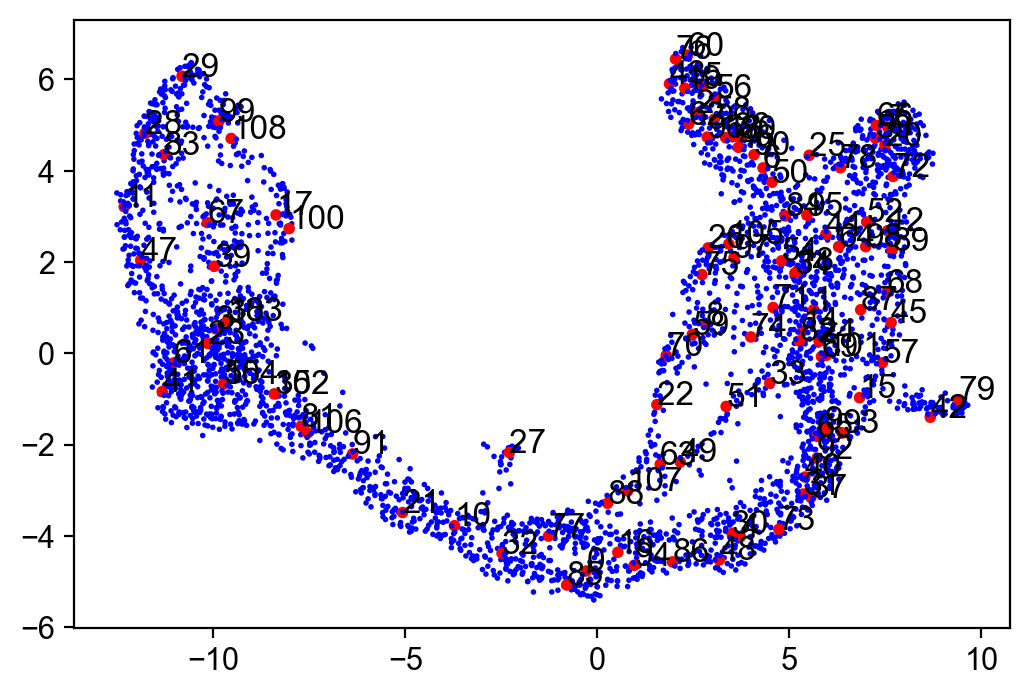

In [ ]:
# make knots larger sizes for plotting
sizes = np.array([1]*X.shape[0])
sizes[nnx[:,0]] = 10
colors = ['red' if i in nnx[:,0] else 'blue' for i in range(X.shape[0])]
fig, ax = plt.subplots()
ax.scatter(adata2000.obsm["X_umap"][:,0],adata2000.obsm["X_umap"][:,1], s=sizes ,c=colors)
for i in range(len(knots)):
    ax.annotate(str(i), (adata2000.obsm["X_umap"][:,0][nnx[i,0]], adata2000.obsm["X_umap"][:,1][nnx[i,0]]))
plt.show()

In [ ]:
# create a graph layout same as the above UMAP positions
coords = [ [adata2000.obsm["X_umap"][:,0][nnx[i,0]], adata2000.obsm["X_umap"][:,1][nnx[i,0]]] for i in range(len(knots)) ]
layout_r = igraph.Layout(coords)

In [ ]:
# calculate the voronoi weights with refined knots
m = knots.shape[0]
voron_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
for i in range(m-1): #loop through knots pairs
    center1 = knots[i]
    wi1 = np.where(X_nn[:,0] == i)[0]
    wi2 = np.where(X_nn[:,1] == i)[0]
    for j in range(i+1,m):
        center2 = knots[j]
        wj1 = np.where(X_nn[:,0] == j)[0]
        wj2 = np.where(X_nn[:,1] == j)[0]
        #data point indices within 2nn neighborhood of knots i, j
        nn2ij = np.union1d(np.intersect1d(wi1, wj2), np.intersect1d(wi2, wj1))
    
        if len(nn2ij) < 1 :#not in Delaunnay Triangulation
            voron_weights[i,j] = 0.0
            continue
    
        # Euclidean distance between two centers
        d12 = kkdists[i,j]

        #compute the Voronoi density 
        voron_weights[i,j] = len(nn2ij)/d12
    
skeleton_r.update( {"voron_weights": voron_weights + np.transpose((voron_weights))})

In [ ]:
# Segment Skeleton
# leaving the graph as a whole in this case, but just run this for essential quantities
import skeleton_methods.clustering as skelclus
knots = skeleton_r["centers"]
X_knotlabels = skeleton_r["cluster"]

#similarities
weights = skeleton_r["voron_weights"]
kcut = 1
hclustKnot = skelclus.cluster_weights(weights, X_knotlabels, kcut = kcut, method='average')

tol = 1e-10
#choose correct cut
cutheight = hclustKnot["hclust"][-kcut][2]
#cut some edges
weights[weights<(np.max(weights)-cutheight+tol)] = 0

#Euclidean distance between centers
kkdists = distance_matrix(knots,knots)
kkdists[weights == 0] = 0

skeleton_r.update({"kkdists": kkdists, "cutWeights": weights, "g" :g}) 



In [ ]:
import pickle
# save the computed skeleton
pickle.dump(skeleton_r, open("Msskeleton_r.pkl", "wb"))
# save the layout
pickle.dump(layout_r, open("Mslayout_r.pkl", "wb"))

In [ ]:
# Just need to load with new code running process
import pickle
skeleton_r = pickle.load(open("Msskeleton_r.pkl","rb"))
layout_r = pickle.load(open("Mslayout_r.pkl","rb"))

<Axes: >

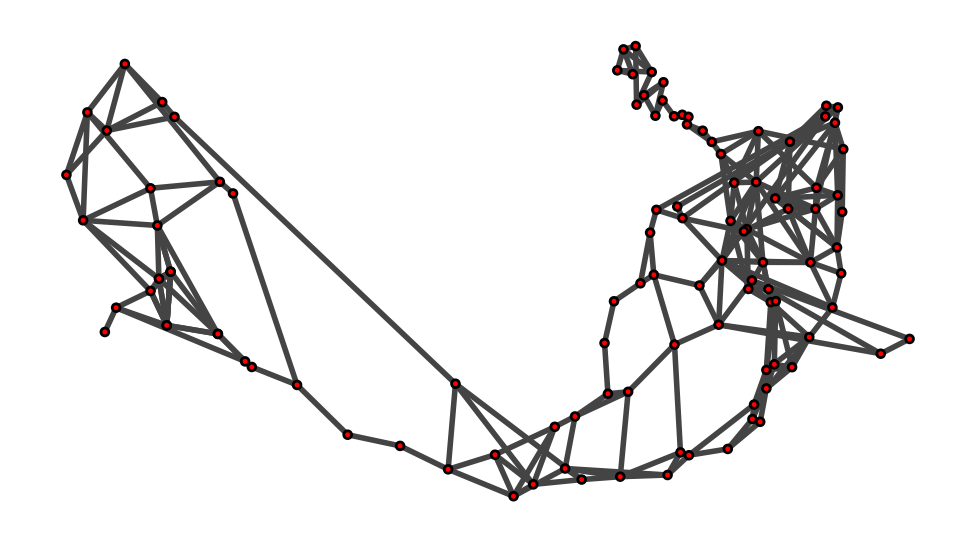

In [ ]:
# plotting using the same layout us UMAP

# import random
# random.seed(1234)
g = igraph.Graph.Weighted_Adjacency(skeleton_r["kkdists"].tolist(),  mode='undirected')
fig, ax = plt.subplots()
# layout_r = g.layout("kk")
igraph.plot(g, layout=layout_r, target=ax)

<Axes: >

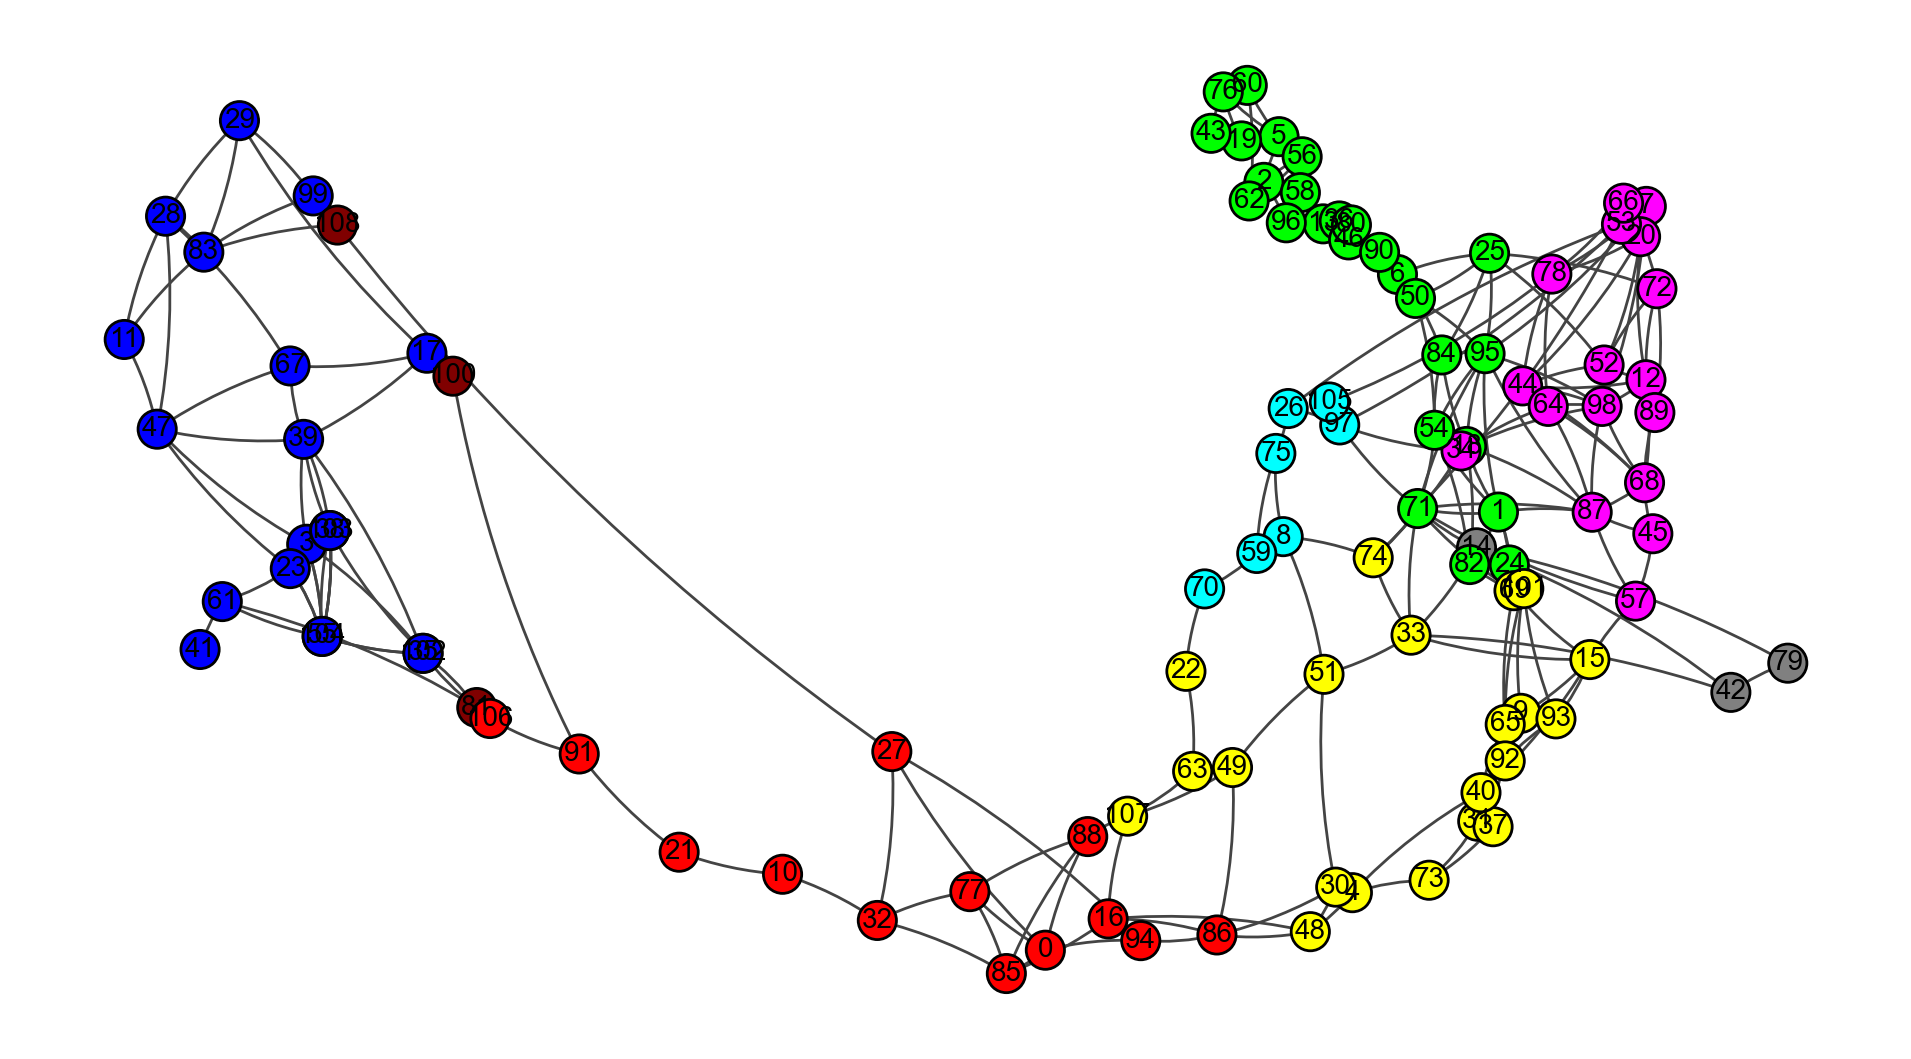

In [ ]:
# color the knots with the major cell type in each
from collections import defaultdict
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adata2000.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]
id_gen = igraph.UniqueIdGenerator()
color_indices = [id_gen.add(value) for value in majorCellClus]
palette = igraph.ClusterColoringPalette(len(id_gen))
colors = [palette[index] for index in color_indices]
g.vs["color"] = colors 

g.vs["label"] = [i for i in range(len(knots))]


fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(g, layout=layout_r, target=ax, autocurve = True,edge_curved="0.1", edge_width = 1,vertex_size = 0.5, vertex_label_size = 10)

color index,  color,  type

0             red        'Ngn3 high EP'

1             green      'Beta'

2             dark blue  'Ductal'

3             yellow     'Pre-endocrine'

4             purple     'Alpha'

5             cyan        'Epsilon'

6             gray        'Delta'

7             brown       'Ngn3 low EP'



In [ ]:
[id_gen.add(value) for value in np.unique(majorCellClus)] 

[4, 1, 6, 2, 5, 0, 7, 3]

In [ ]:
np.unique(majorCellClus)

array(['Alpha', 'Beta', 'Delta', 'Ductal', 'Epsilon', 'Ngn3 high EP',
       'Ngn3 low EP', 'Pre-endocrine'], dtype='<U13')

In [ ]:
for value in range(8):
    print([i for i in range(len(color_indices)) if color_indices[i] == value])

[0, 10, 16, 21, 27, 32, 77, 85, 86, 88, 91, 94, 106]
[1, 2, 5, 6, 13, 18, 19, 24, 25, 36, 43, 46, 50, 54, 56, 58, 60, 62, 71, 76, 80, 82, 84, 90, 95, 96]
[3, 11, 17, 23, 28, 29, 38, 39, 41, 47, 55, 61, 67, 83, 99, 102, 103, 104]
[4, 9, 15, 22, 30, 31, 33, 37, 40, 48, 49, 51, 63, 65, 69, 73, 74, 92, 93, 101, 107]
[7, 12, 20, 34, 44, 45, 52, 53, 57, 64, 66, 68, 72, 78, 87, 89, 98]
[8, 26, 59, 70, 75, 97, 105]
[14, 42, 79]
[35, 81, 100, 108]


# Aggregate cell-level velocity graph to get knot level similarity graph

In [ ]:
# take the mean of cell-level cosine similarities for knot-level similarities
velocity_graph = adata2000.uns["velocity_graph"]
layout_r = pickle.load(open("Mslayout_r.pkl","rb"))
skeleton_r = pickle.load(open("Msskeleton_r.pkl","rb"))
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]
voron_weights = skeleton_r["voron_weights"]

idxSet = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    idxSet[i] = skeleton_r["cluster"] == i

knot_velocity_graph = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(len(knots)):
        mat = velocity_graph[idxSet[i]][:, idxSet[j]]
        if mat.count_nonzero() == 0:
            knot_velocity_graph[i,j] = 0
        else:
            knot_velocity_graph[i,j] = mat.sum() / mat.count_nonzero()


In [ ]:
# remove some edges according to the constructed skeleton
knot_velocity_graph[skeleton_r["voron_weights"]==0]=0
thres = np.median(knot_velocity_graph[knot_velocity_graph > 0])
knot_velocity_graph1 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(i+1,len(knots)):
        if knot_velocity_graph[i,j] < knot_velocity_graph[j,i]:
            knot_velocity_graph1[j,i] = knot_velocity_graph[j,i]
            if knot_velocity_graph[i,j] > thres:
                knot_velocity_graph1[i,j] = knot_velocity_graph[i,j]
        else:
            knot_velocity_graph1[i,j] = knot_velocity_graph[i,j]
            if knot_velocity_graph[j,i] > thres:
                knot_velocity_graph1[j,i] = knot_velocity_graph[j,i]

# construct the igraph object for graph
velog_1e = igraph.Graph.Weighted_Adjacency(knot_velocity_graph1.tolist(),  mode='directed') 

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adata2000.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]

id_gen = igraph.UniqueIdGenerator()
vcolor_indices = [id_gen.add(value) for value in majorCellClus]
palette = igraph.ClusterColoringPalette(len(id_gen))
vcolors = [palette[index] for index in vcolor_indices]
velog_1e.vs["color"] = vcolors 

velog_1e.vs["label"] = [i for i in range(len(knots))]

edgeWeightCat = (np.round(np.array(velog_1e.es["weight"])*3)).astype(int)
palette = igraph.ClusterColoringPalette(len(edgeWeightCat))
edgecolors = [palette[index] for index in edgeWeightCat]
velog_1e.es["color"] = edgecolors 

velog_1e.es['width'] = np.sqrt(edgeWeightCat)*2 + 1



In [ ]:
# specify graph plotting layout using kk algorithm
# the UMAP based layout is not working, so a kk algorithm based layout here


# layout0 = velog_1e.layout("kk")
# layout0.rotate(90)
# layout0.mirror(1)
import pickle
# pickle.dump(layout0, open("Mslayout0.pkl", "wb"))
layout0 = pickle.load(open("Mslayout0.pkl","rb"))

<Axes: >

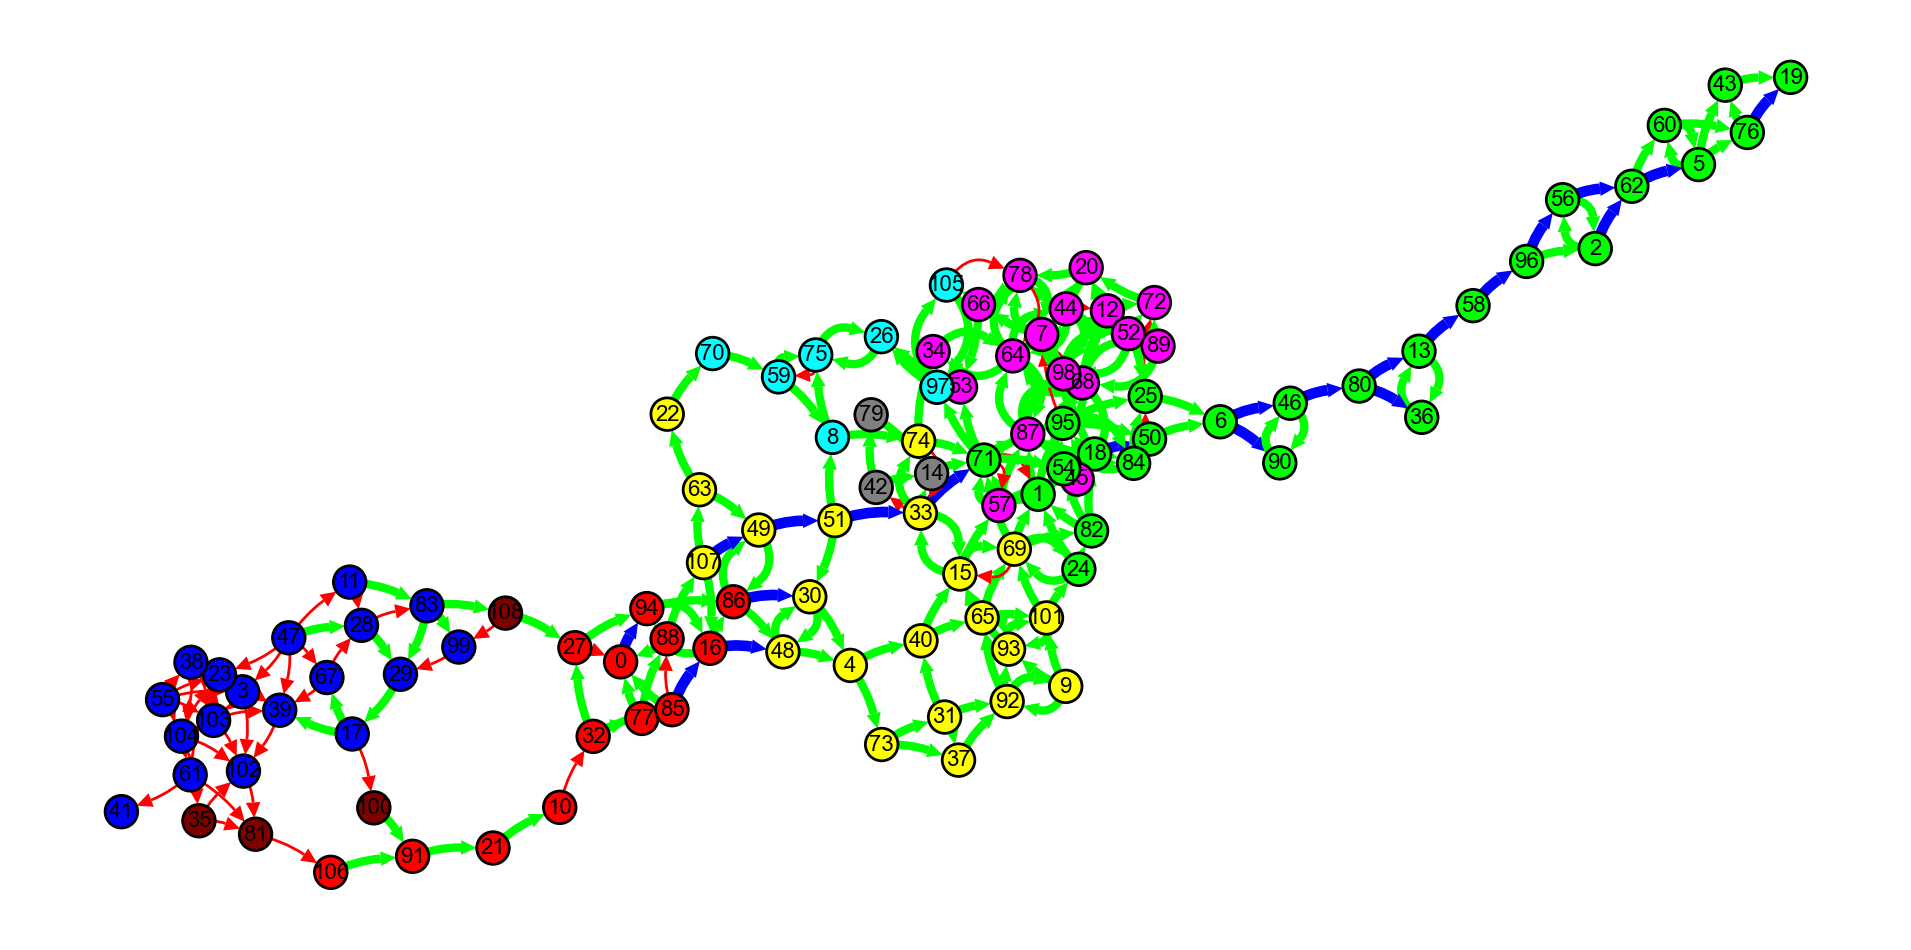

In [ ]:

fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(velog_1e, layout=layout0, target=ax, autocurve = True,edge_curved="0.1", vertex_size = 0.2, vertex_label_size = 8)

# Average the cell velocities within neighborhood as knot velocity and then calculate knot-level cosine similarity

In [ ]:
# Compute knot velocity

# nans = np.isnan(np.sum(velocity, axis=0))
# if np.any(nans):
#     X = X[:, ~nans]
#     velocity = velocity[:, ~nans]
velocity = V

knots = skeleton_r["centers"]
voron_weights = skeleton_r["voron_weights"]

from collections import defaultdict
idxSet = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    idxSet[i] = skeleton_r["cluster"] == i

knot_velocity = np.array([[0.0 for _ in  range(velocity.shape[1])] for _ in range(len(knots))])
for i in range(len(knots)):
    knot_velocity[i,:] = np.mean(velocity[idxSet[i],:], axis = 0)

knot_X = np.array([[0.0 for _ in  range(X.shape[1])] for _ in range(len(knots))])
for i in range(len(knots)):
    knot_X[i,:] = np.mean(X[idxSet[i],:], axis = 0)

In [ ]:
# use knot velocity to get cosine similarity graph between knots

from numpy.linalg import norm
knot_velocity_graph_direct0 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(len(knots)):
        if i != j and voron_weights[i,j] > 0:
            xdiff = knot_X[j,:]-  knot_X[i,:]
            knot_velocity_graph_direct0[i,j] = np.dot(knot_velocity[i,:], xdiff)/(norm(xdiff)*norm(knot_velocity[i,:]))

In [ ]:
# For plotting
thres = np.quantile(knot_velocity_graph_direct0[knot_velocity_graph_direct0 > 0], 0.3)

knot_velocity_graph1 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(i+1,len(knots)):
        if knot_velocity_graph_direct0[i,j] < knot_velocity_graph_direct0[j,i]:
            knot_velocity_graph1[j,i] = knot_velocity_graph_direct0[j,i]
            if knot_velocity_graph_direct0[i,j] > thres:
                knot_velocity_graph1[i,j] = knot_velocity_graph_direct0[i,j]
        else:
            knot_velocity_graph1[i,j] = knot_velocity_graph_direct0[i,j]
            if knot_velocity_graph_direct0[j,i] > thres:
                knot_velocity_graph1[j,i] = knot_velocity_graph_direct0[j,i]

<Axes: >

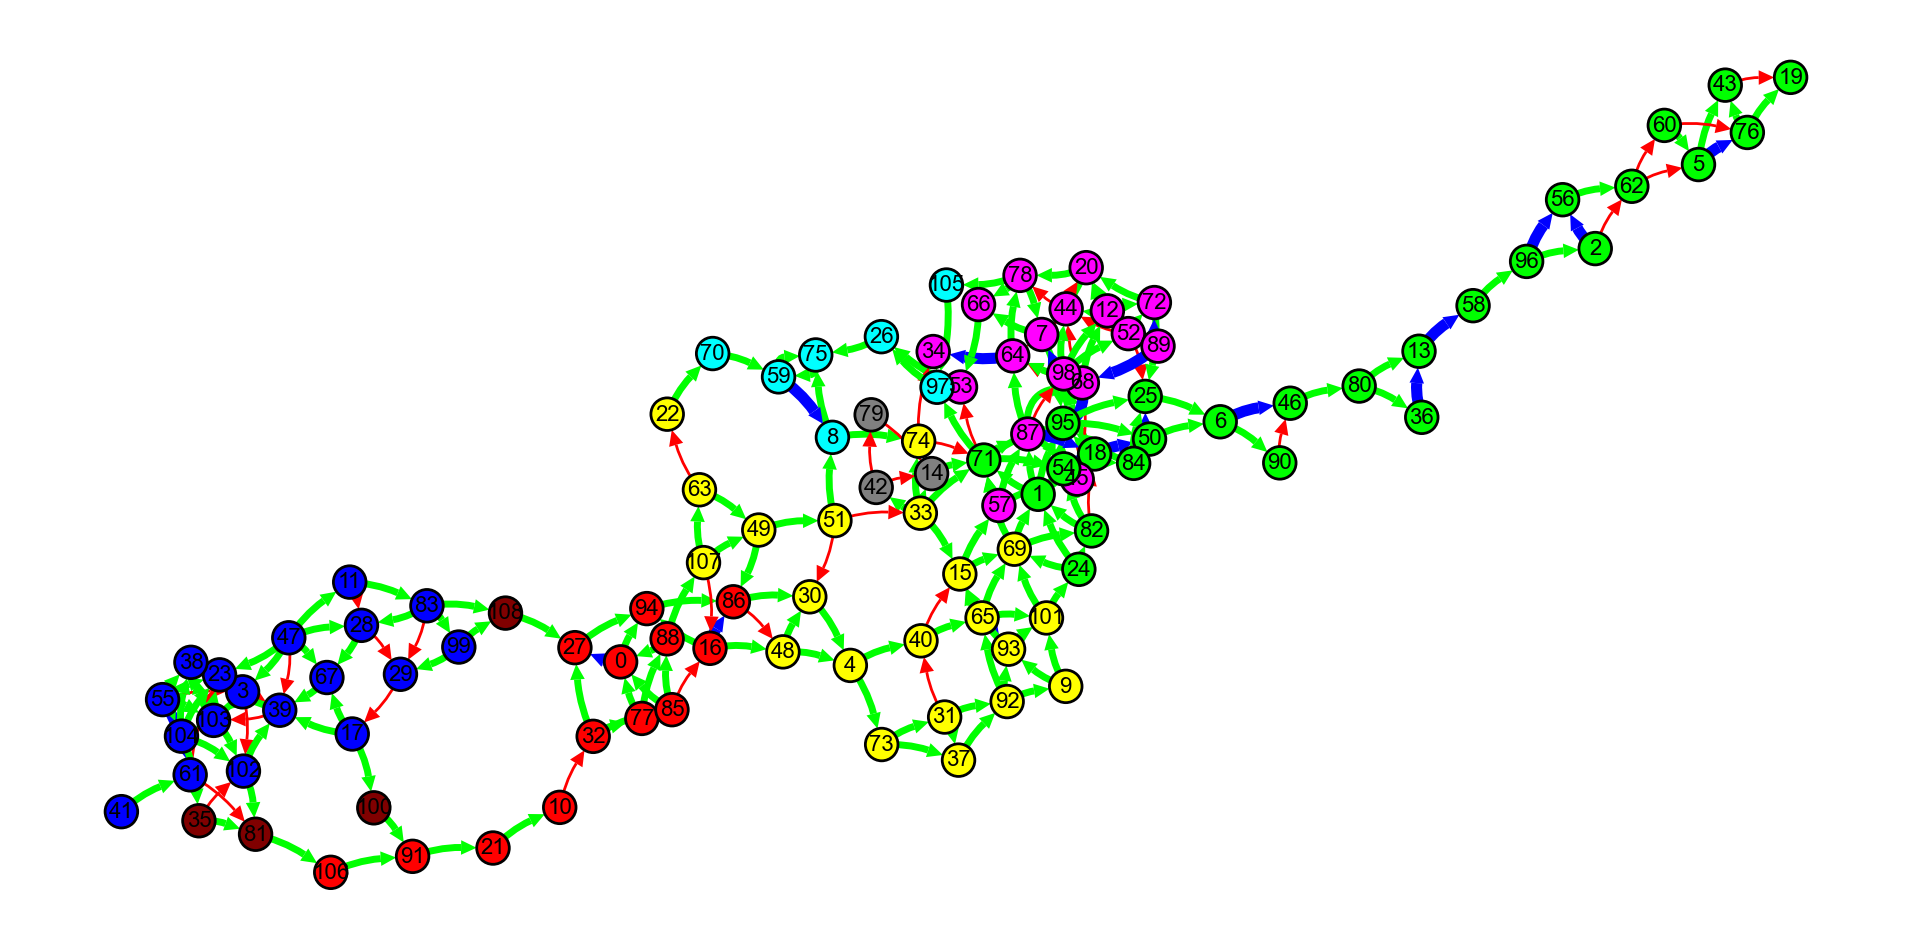

In [ ]:
velog_r = igraph.Graph.Weighted_Adjacency(knot_velocity_graph1.tolist(),  mode='directed') 

from collections import defaultdict
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adata2000.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]

id_gen = igraph.UniqueIdGenerator()
vcolor_indices = [id_gen.add(value) for value in majorCellClus]
palette = igraph.ClusterColoringPalette(len(id_gen))
vcolors = [palette[index] for index in vcolor_indices]
velog_r.vs["color"] = vcolors 

velog_r.vs["label"] = [i for i in range(len(knots))]

# bins = np.quantile(np.array(velog_r.es["weight"]), [0,0.33, 0.67,1])
# bins[0] = bins[0] -1
# bins[-1] = bins[-1] +1
# edgeWeightCat = pd.cut(pd.Series(velog_r.es["weight"]), bins)
# edgeWeightCatcode = edgeWeightCat.cat.codes

edgeWeightCatcode =(np.round(np.array(velog_1e.es["weight"])*3)).astype(int)

palette = list(igraph.ClusterColoringPalette(len(np.unique(edgeWeightCatcode))))
# palette[3] = (0.0, 0.0, 0.0, 1.0)
edgecolors = [palette[index] for index in edgeWeightCatcode]
velog_r.es["color"] = edgecolors 

velog_r.es['width'] = edgeWeightCatcode*1.5 + 1


fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(velog_r, layout=layout0, target=ax, autocurve = True,edge_curved="0.1",vertex_size = 0.2, vertex_label_size = 8)

## Comparison with using the cell-level velocity_graph results

In [ ]:
knot_velocity_graph.shape
knot_velocity_graph_direct0.shape
np.sum((knot_velocity_graph - knot_velocity_graph_direct0)**2) 

45.71975784965817

In [ ]:
knot_velocity_graph_direct0[23]

array([ 0.        ,  0.        ,  0.        , -0.18344018,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.12049461,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.14294522,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.18119334,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.13616818,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [ ]:
knot_velocity_graph[23]

array([0.        , 0.        , 0.        , 0.06292675, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05645442, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05571425, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05789798, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10181004, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
# cosine between cell velocities and knot velocity
# picking knot 23 as the neighborhood for illustration
np.sort(scv.tl.utils.cosine_correlation(velocity[idxSet[23],:], knot_velocity[23,:]))

array([[0.71615786, 0.72795017, 0.73787634, 0.73809644, 0.74943064,
        0.77099629, 0.77678999, 0.77905032, 0.79451693, 0.79527203,
        0.80122963, 0.80405018, 0.81083234, 0.81421087, 0.81598096,
        0.81840218, 0.82031511, 0.82075019, 0.82075246, 0.82203441,
        0.82405828, 0.82497367, 0.82705063, 0.82915513, 0.82931865,
        0.83217764, 0.83222105, 0.83408659, 0.83521481, 0.83540121,
        0.83717918, 0.84021213, 0.8404421 , 0.8436386 , 0.8465567 ,
        0.84888247, 0.85166137, 0.85698412, 0.85748684, 0.86119422,
        0.86322578, 0.86511418, 0.86813179, 0.87043467, 0.8706293 ,
        0.87215514, 0.87225064, 0.87266502, 0.87479232, 0.87596785,
        0.87624906, 0.87929597, 0.88207189, 0.88285464, 0.88322067,
        0.88501756, 0.88852343, 0.88886994, 0.8901731 , 0.89149189,
        0.89384432, 0.89394695, 0.895153  , 0.89639886, 0.89838555,
        0.90015393, 0.90041648, 0.9004804 , 0.90138831, 0.90262589,
        0.9051079 , 0.90919119, 0.9092997 , 0.91

In [ ]:
np.quantile(scv.tl.utils.cosine_correlation(velocity[idxSet[23],:], knot_velocity[23,:]), [0,0.25,0.5,0.75,1])


array([0.71615786, 0.82757675, 0.87139222, 0.90046442, 0.94059555])

In [ ]:
# the original velocity_graph subportion
subVeloGraph = velocity_graph[idxSet[23]][:, idxSet[13]].toarray()
subVeloGraph[subVeloGraph>0].shape

(0,)

In [ ]:
subVeloGraph[subVeloGraph>0].mean()

nan

In [ ]:
# import seaborn as sns
# # Make default density plot
# sns.kdeplot(subVeloGraph[subVeloGraph>0])

import matplotlib.pyplot as plt

density = np.histogram(subVeloGraph[subVeloGraph>0], density=True)

plt.hist(subVeloGraph[subVeloGraph>0], bins=100, density=True)
plt.show()

From this, we note that the cosine similarity between the cells in the two neighborhoods are weak overall but are all non-negative. But this negativeness is by the scVelo procedure that separates the negative cosine similarities into a separate matrix call "velocity_graph_neg". 

In [ ]:
np.max(adata2000.uns["velocity_graph_neg"])

0.0

In [ ]:
subVeloGraph_neg = adata2000.uns["velocity_graph_neg"][idxSet[23]][:, idxSet[13]].toarray()
subVeloGraph_neg[subVeloGraph_neg<0].shape

(127,)

In [ ]:
np.concatenate((subVeloGraph_neg[subVeloGraph_neg<0], subVeloGraph[subVeloGraph>0]))

0.14702255

In [ ]:
subVeloGraph_neg[subVeloGraph_neg<0].mean()

-0.055257577

There are not that many negative entreis, and combining the negative and positive cell-wise cosine similarities together doesn't change the mean much. But the cosine similarity based on the knot velocity is negative with some strength.

Feel the way existing literature generates plots by embedding the velocity first or use the velocity_graph (with only positive entries) do implicitly carry out some smoothing of the velocity and hence arrives at good visualizations.

# Use projection (with length information) instead of cosine for similarity

In [ ]:
# layout_r = pickle.load(open("layout_r.pkl","rb"))[0]
# skeleton_r = pickle.load(open("skeleton_r.pkl","rb"))


# knots = skeleton_r["centers"]
# voron_weights = skeleton_r["voron_weights"]

# from collections import defaultdict
# idxSet = defaultdict(lambda: "Not Present")
# for i in range(len(knots)):
#     idxSet[i] = skeleton_r["cluster"] == i

# knot_velocity = np.array([[0.0 for _ in  range(velocity.shape[1])] for _ in range(len(knots))])
# for i in range(len(knots)):
#     knot_velocity[i,:] = np.mean(velocity[idxSet[i],:], axis = 0)

from numpy.linalg import norm
knot_velocity_graph_direct = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(len(knots)):
        if i != j and voron_weights[i,j] > 0:
            xdiff = knot_X[j,:]-  knot_X[i,:]
            knot_velocity_graph_direct[i,j] = np.dot(knot_velocity[i,:], xdiff)/norm(xdiff)


In [ ]:
# # to reverse the arrows for negative directions
# knot_velocity_graph1 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
# for i in range(len(knots)):
#     for j in range(len(knots)):
#         if knot_velocity_graph[i,j] > 0:
#              knot_velocity_graph1[i,j] = knot_velocity_graph_direct[i,j]
thres = np.quantile(knot_velocity_graph_direct[knot_velocity_graph_direct > 0], 0.3)

knot_velocity_graph1 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(i+1,len(knots)):
        if knot_velocity_graph_direct[i,j] < knot_velocity_graph_direct[j,i]:
            knot_velocity_graph1[j,i] = knot_velocity_graph_direct[j,i]
            if knot_velocity_graph_direct[i,j] > thres:
                knot_velocity_graph1[i,j] = knot_velocity_graph_direct[i,j]
        else:
            knot_velocity_graph1[i,j] = knot_velocity_graph_direct[i,j]
            if knot_velocity_graph_direct[j,i] > thres:
                knot_velocity_graph1[j,i] = knot_velocity_graph_direct[j,i]

<Axes: >

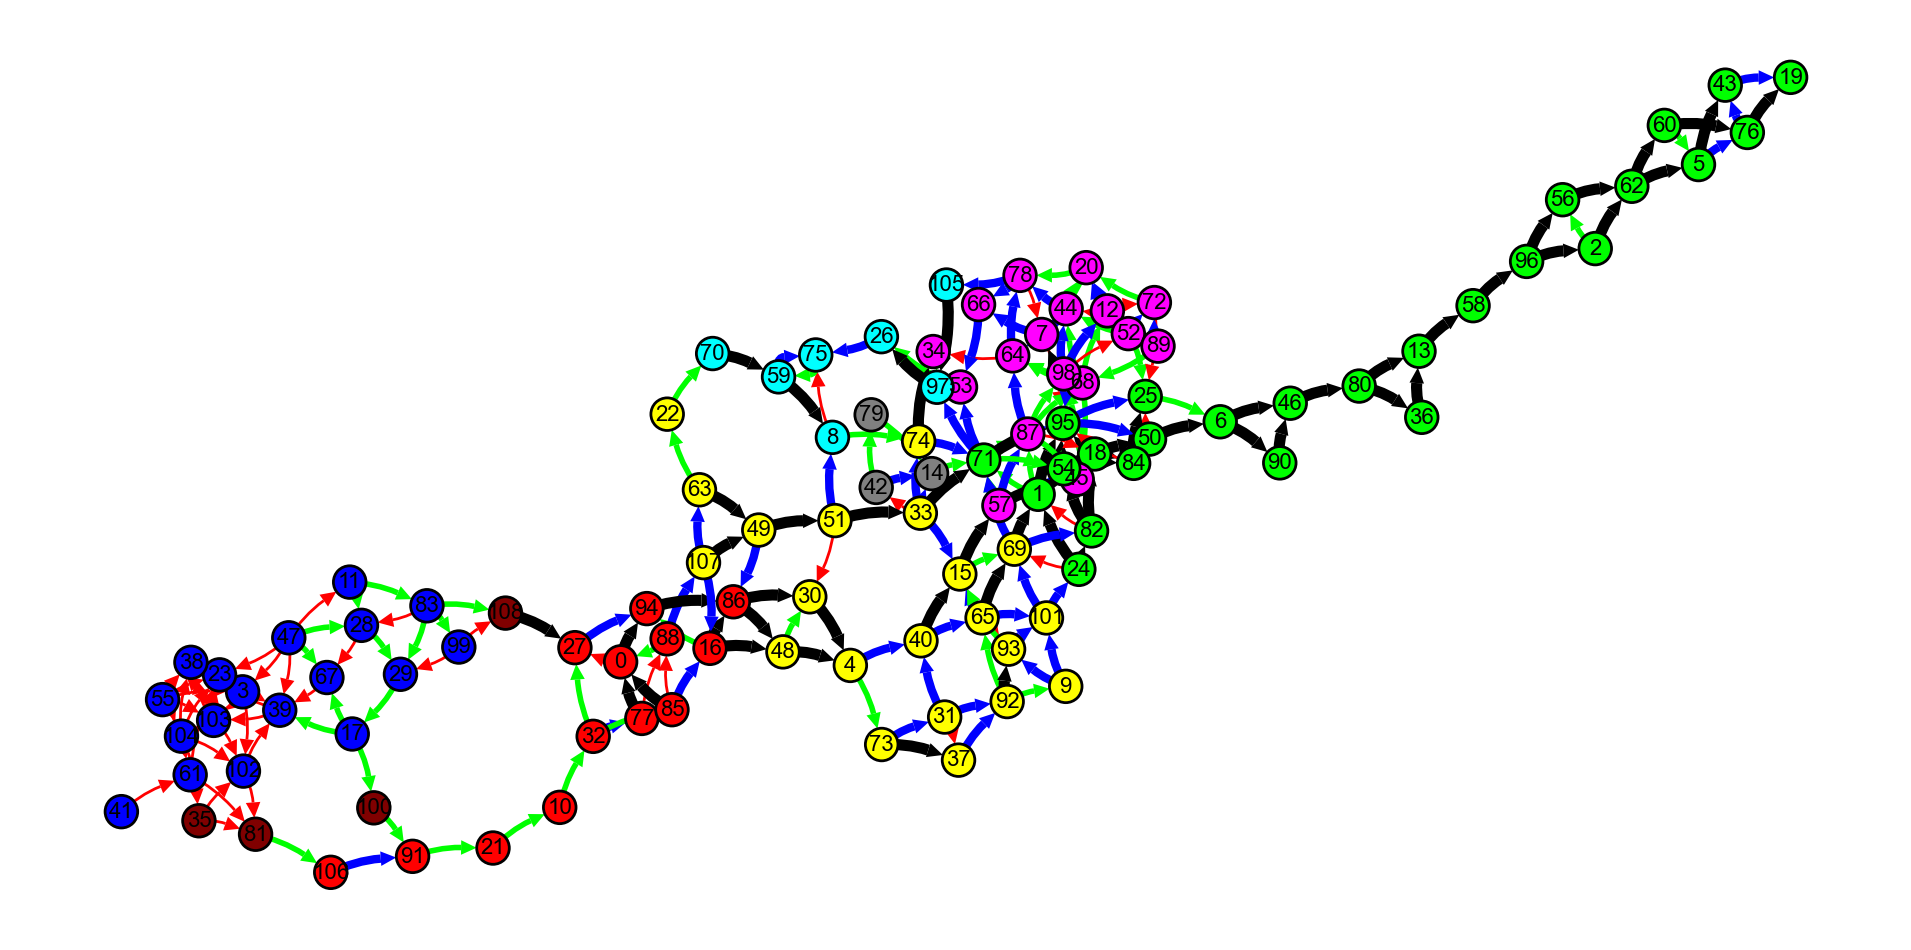

In [ ]:
velog_r = igraph.Graph.Weighted_Adjacency(knot_velocity_graph1.tolist(),  mode='directed') 

from collections import defaultdict
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adata2000.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]

id_gen = igraph.UniqueIdGenerator()
vcolor_indices = [id_gen.add(value) for value in majorCellClus]
palette = igraph.ClusterColoringPalette(len(id_gen))
vcolors = [palette[index] for index in vcolor_indices]
velog_r.vs["color"] = vcolors 

velog_r.vs["label"] = [i for i in range(len(knots))]

bins = np.quantile(np.array(velog_r.es["weight"]), [0, 0.33, 0.67 ,1])
bins[0] = bins[0] -1
bins[-1] = bins[-1] +1
edgeWeightCat = pd.cut(pd.Series(velog_r.es["weight"]), bins)
edgeWeightCatcode = edgeWeightCat.cat.codes

palette = list(igraph.ClusterColoringPalette(len(np.unique(edgeWeightCatcode))))
palette[3] = (0.0, 0.0, 0.0, 1.0)
edgecolors = [palette[index] for index in edgeWeightCatcode]
velog_r.es["color"] = edgecolors 

velog_r.es['width'] = edgeWeightCatcode + 1


fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(velog_r, layout=layout0, target=ax, autocurve = True,edge_curved="0.1",vertex_size = 0.2, vertex_label_size = 8)

# Laplacian Eigenmap/Diffusion map projection

In [ ]:
import pickle
skeleton_r = pickle.load(open("Msskeleton_r.pkl","rb"))
layout_r = pickle.load(open("Mslayout_r.pkl","rb"))
layout0 = pickle.load(open("Mslayout0.pkl","rb"))

adata2000 = scv.read('data/pancreasd2000.h5ad')

X = adata2000.layers["Ms"]
V = adata2000.layers["velocity"]

subset = np.ones(adata2000.n_vars, bool)
subset &= np.array( adata2000.var["velocity_genes"].values, dtype = bool)
X = X[:, subset]
V = V[:, subset]
nans = np.isnan(np.sum(V, axis=0))
if np.any(nans):
    X = X[:, ~nans]
    V = V[:, ~nans]
V -= np.nanmean(V, axis =1)[:,None]

In [ ]:
# Laplacian eigenmap embedding

from sklearn.manifold import SpectralEmbedding
LEembedding = SpectralEmbedding(n_components=100)
X_LE = LEembedding.fit_transform(X)
X_LE.shape

(3696, 100)

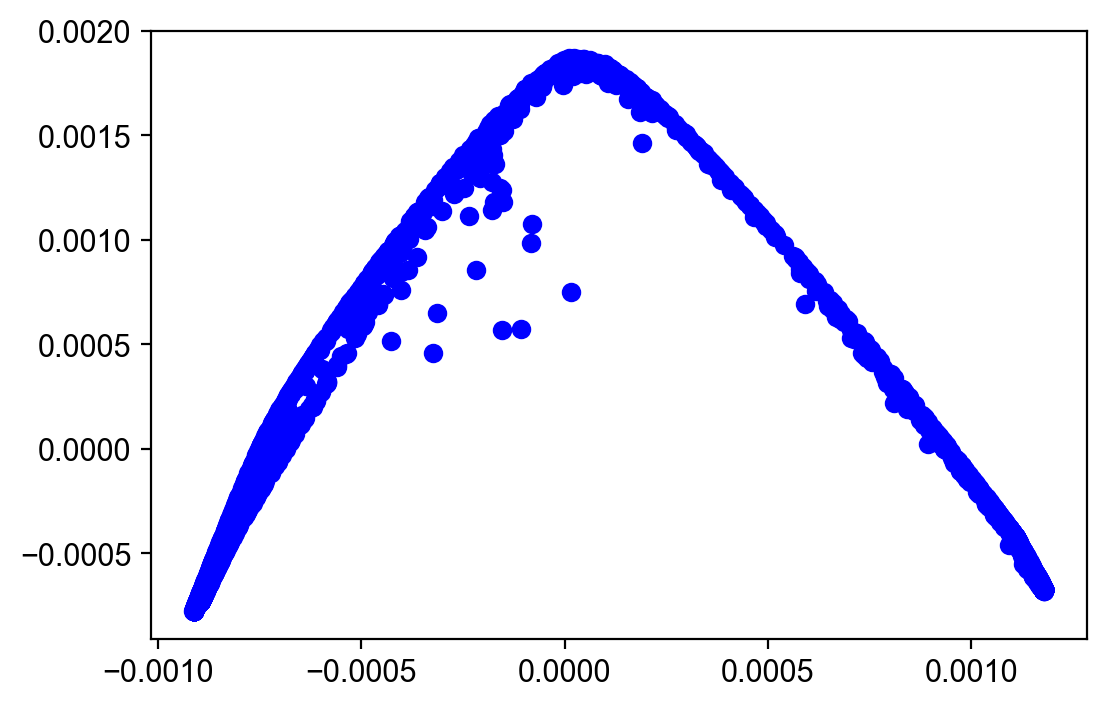

In [ ]:
plt.scatter(X_LE[:,0], X_LE[:,1], c ="blue")
 
# To show the plot
plt.show()

In [ ]:
# # Diffusion map embedding. Not working properly for now
# from pydiffmap import diffusion_map as dm
# DMembedding = dm.DiffusionMap.from_sklearn(n_evecs = 10, alpha = 0.5, epsilon = 'bgh', k=200)
# X_DM = DMembedding.fit_transform(X)

KeyboardInterrupt: 

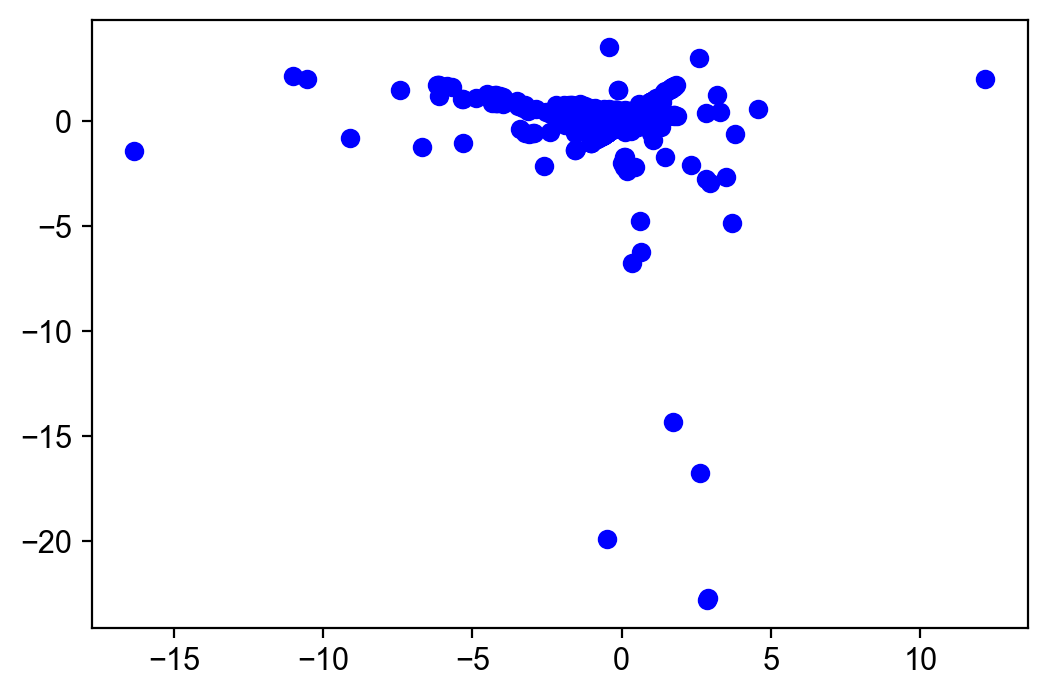

In [ ]:
plt.scatter(X_DM[:,99], X_DM[:,98], c ="blue")
 
# To show the plot
plt.show()

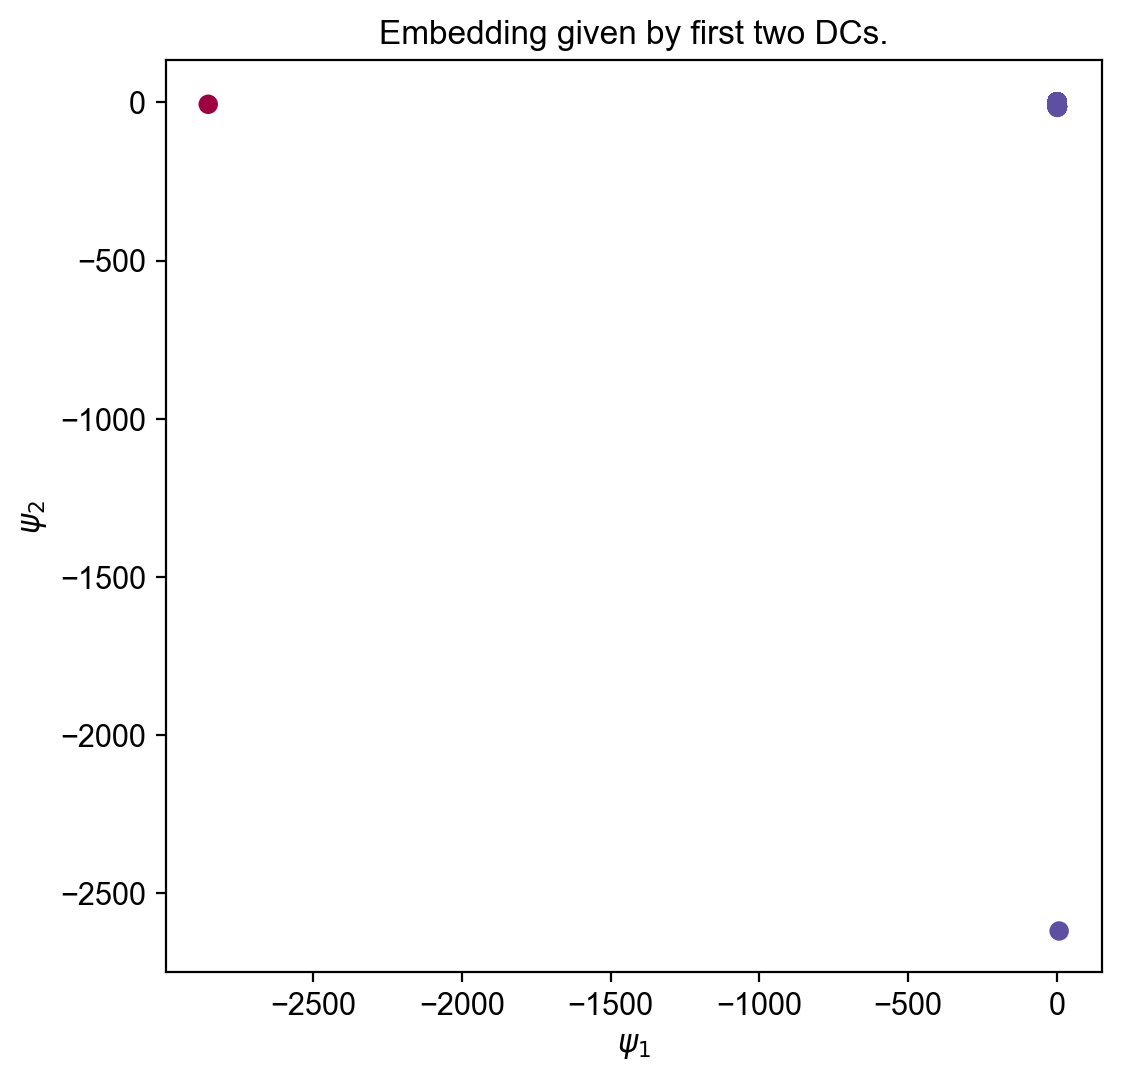

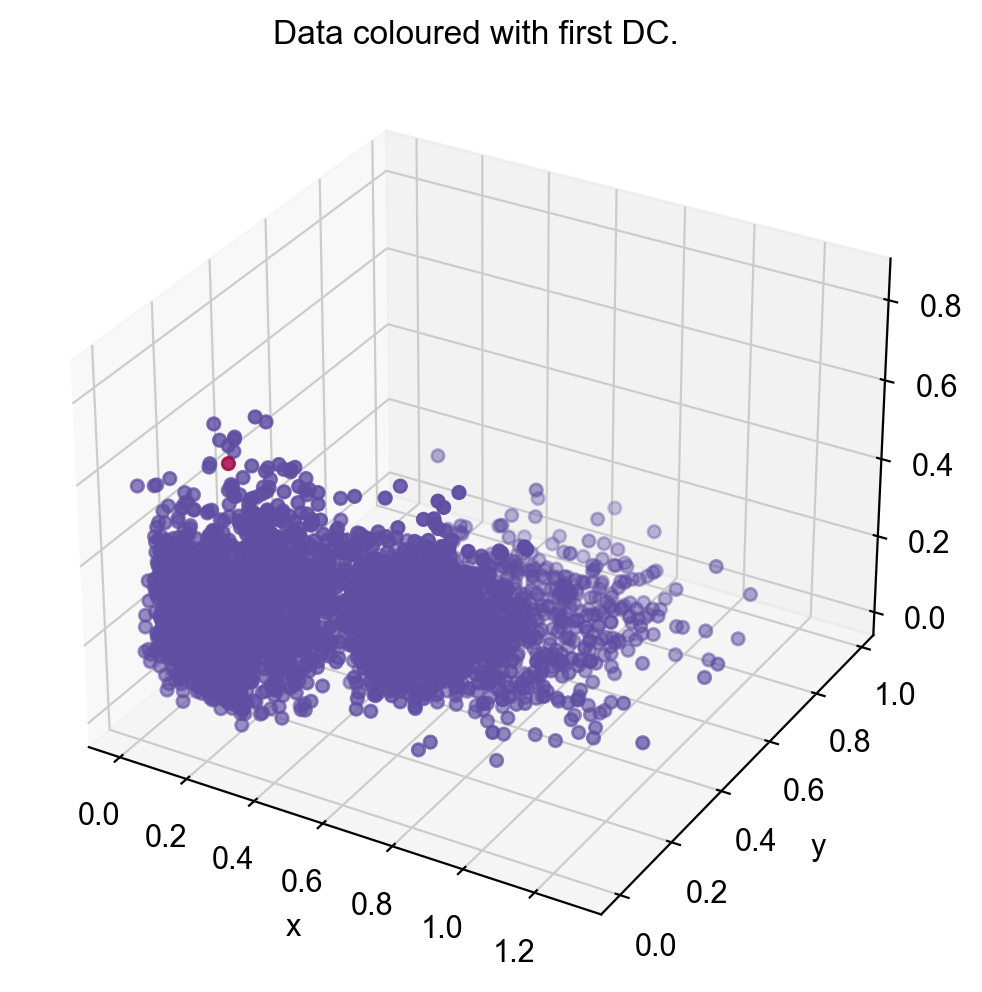

In [ ]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(DMembedding, scatter_kwargs = {'c': X_DM[:,0], 'cmap': 'Spectral'})
data_plot(DMembedding, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()